In [10]:
import pandas as pd
from business_models import hahn
from scipy import stats
import matplotlib.pyplot as plt

In [6]:
with open('collect_order_for_check.sql', 'r') as query_file:
    query = query_file.read()
df = hahn(query.format('2020-03-16'),
         syntax_version = 1)

No handlers could be found for logger "yql.client.request"


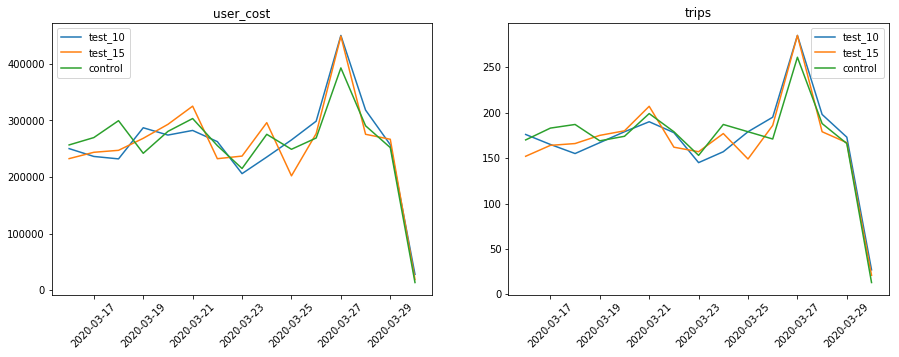

In [14]:
# Посмотреть совпадают ли линии
df['local_order_dt'] = pd.to_datetime(df.local_order_dt)
group_money = df.groupby(['group_tag', 'local_order_dt'])['user_cost'].sum().reset_index()
group_trips = df.groupby(['group_tag', 'local_order_dt'])['order_id'].count().reset_index()

groups = ['test_10', 'test_15', 'control']
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

def plot_metric(df, metric, ax):
    for grp in groups:
        _tmp = df[df.group_tag == grp]
        axes[ax].plot(_tmp.local_order_dt, _tmp[metric], label = grp)
    axes[ax].legend()
#     axes[ax].axvline('2020-03-01', ls = '--', color = 'r')
    for tick in axes[ax].get_xticklabels():
        tick.set_rotation(45)
        
plot_metric(group_money, 'user_cost', 0)
axes[0].set_title('user_cost')
plot_metric(group_trips, 'order_id', 1)
axes[1].set_title('trips');

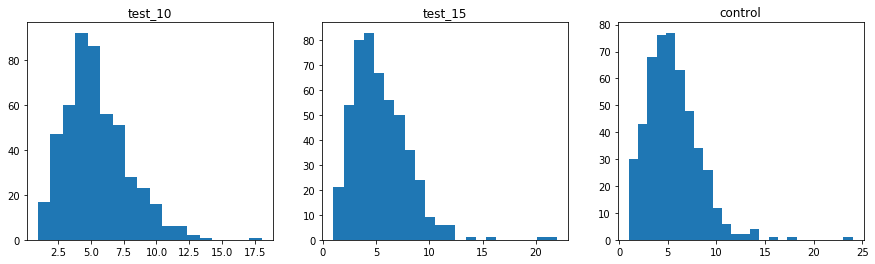

In [51]:
# Сгруппирую по группам и бакетам и посмотрю на распределение заказов. Должно быть похоже на нормальное
grouped = pd.concat([
    df.groupby(['group_tag', 'group_id'])['order_id'].count(),
    df.groupby(['group_tag', 'group_id'])['user_cost'].sum()], axis = 1)
grouped.columns = ['orders', 'user_cost']

fig, axes = plt.subplots(1, 3, figsize = (15, 4))
for n, mtr in enumerate(groups):
    _bin = grouped.loc[mtr, 'orders'].max()
    axes[n].hist(grouped.loc[mtr, 'orders'], bins = _bin)
    axes[n].set_title(mtr)

In [52]:
# Сравню тестовые группы с контролем с помощью т-теста по количеству заказов и по user_cost (деньги которые заплатил полльзователь)
for metric in ['orders', 'user_cost']:
    print('+== Check {} ==+'.format(metric))
    for grp in ['test_10', 'test_15']:
        res = stats.ttest_ind(grouped.loc['control', metric].fillna(0), grouped.loc[grp, metric].fillna(0))
        if res[1] > 0.05:
            conclusion = 'Equal'
        else:
            conclusion = 'Unequal'
        print("""
        %s results with control
        Statistic = %d, p-value = %f, Conclusion = samples are %s   
        ----------------------------------------------------------------------
        """ % (grp, res[0], res[1], conclusion))

+== Check orders ==+

        test_10 results with control
        Statistic = 0, p-value = 0.995805, Conclusion = samples are Equal   
        ----------------------------------------------------------------------
        

        test_15 results with control
        Statistic = 0, p-value = 0.473931, Conclusion = samples are Equal   
        ----------------------------------------------------------------------
        
+== Check user_cost ==+

        test_10 results with control
        Statistic = 0, p-value = 0.815144, Conclusion = samples are Equal   
        ----------------------------------------------------------------------
        

        test_15 results with control
        Statistic = 0, p-value = 0.914098, Conclusion = samples are Equal   
        ----------------------------------------------------------------------
        


In [64]:
# Посчитаю сколько пользователей мне нужно, что бы за 2 недели засечь стат значимость в 10% 
# 10% - потому что при эластичности 1 и скидке 10% трипы должны прирости на 10%, если эластичность ниже, то такой результат не интересен для бизнеса
# референс - https://www.youtube.com/watch?v=GXnCEnsd7M8
z_val_beta = stats.norm.ppf(0.8)
z_val_alpha = stats.norm.ppf(1 - 0.05 / 2)
mean_orders = grouped.orders.mean()
mean_expected_orders = grouped.orders.mean() * 1.1
_std = grouped.orders.std()

sample_n = ((2*_std**2) * (z_val_beta + z_val_alpha)**2) / (mean_expected_orders - mean_orders)**2

print('''
По расчетам, n должно равнаться %d
Но так как n это бакет, то нужно домножить на 1721, потому что в среднем столько пользователей в каждом бакете
1721 * %d = %d
Столько пользоватей нужно для эксперимента
''' % (sample_n, sample_n, sample_n * 1721))


По расчетам, n должно равнаться 423
Но так как n это бакет, то нужно домножить на 1721, потому что в среднем столько пользователей в каждом бакете
1721 * 423 = 729636
Столько пользоватей нужно для эксперимента

